In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [3]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
# import tensorflow as tf
# tf.__version__

## Load raw data

In [4]:
pwd

'/tf/notebooks/final-project/Classification'

In [5]:
!head -2 /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt

speech_id|speech
970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for th

In [6]:
!cat /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt | wc -l

283399


In [5]:
data_path = '/home/yulia/final-project/data/raw/hein-daily'

In [6]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [7]:
len(all_speech_ids), len(all_speeches)

(3866201, 3866201)

## Create target labels

In [2]:
!cat /tf/notebooks/final-project/data/QA/full_descr.txt | wc -l

2914465


In [ ]:
# OPEN descr FROM A SAVED FILE (if it was previously saved)
outdata_path = '/home/yulia/final-project/Classification/data'
descr = pickle.load(open(os.path.join(outdata_path, 'descr.p'), 'rb'))

37,617 fuzzy match speeches had multiple duplicates. Delete them from the dictionary

In [9]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data('/home/yulia/final-project/data/QA/full_descr.txt')
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1090182100
date 20061114
char_count 278
word_count 49
speakerid 109112991.0
Party R
Congress 109
Chamber S
State TN
Ethnicity W
Age 54.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. FRIST
Full Name FRIST, WILLIAM
match exact
check 1

It took 20.8 seconds to create the dictionary


In [10]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.9634876258550458

In [11]:
gender = load_data.create_target_labels(all_speech_ids, descr)[0]
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(3866201, 3866201, 3866201, 3866201, 3866201, 3866201)

### Save descr dictionary

In [233]:
#outdata_path = '/tf/notebooks/final-project/Classification/data'

In [12]:
#pickle.dump(descr, open(os.path.join(outdata_path, 'descr.p'), 'wb'))

In [ ]:
#descr = pickle.load(open(os.path.join(outdata_path, 'descr.p'), 'rb'))

### Data QA

In [13]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,2579578
2,1,228472


Target group number of speeches by party:
A: 	 0
D: 	 165834
I: 	 0
N: 	 0
NA: 	 -1058151
P: 	 0
R: 	 62638

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,2566825
2,1,241225


Target group number of speeches by party:
A: 	 21
D: 	 213500
I: 	 64
N: 	 334
NA: 	 -1058151
P: 	 53
R: 	 27253

 Age
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,1836698
2,1,971352


Target group number of speeches by party:
A: 	 21
D: 	 482630
I: 	 360
N: 	 334
NA: 	 -1058151
P: 	 53
R: 	 487954


## Split into train, validate, test

In [14]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 94074 ones and 94074 zeroes
Training speech list size: 188148
Training target list size: 188148
Validation split: 31358 ones and 31358 zeroes
Validation speech list size: 62716
Validation target list size: 62716
Test split: 31358 ones and 31358 zeroes
Test speech list size: 62716
Test target list size: 62716


In [15]:
sum(train_target), sum(val_target), sum(test_target)

(94074, 31358, 31358)

In [16]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

71682

## Load train, validate, test

In [6]:
outdata_path = '/home/yulia/final-project/Classification/data'

In [7]:
with open(os.path.join(outdata_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)

In [8]:
sum(train_target)

94074

In [9]:
with open(os.path.join(outdata_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)

In [10]:
sum(val_target)

31358

In [11]:
with open(os.path.join(outdata_path, 'test_list'), 'rb') as fp:
    test = pickle.load(fp)
with open(os.path.join(outdata_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)

In [12]:
sum(test_target)

31358

## CNN

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [17]:
reload(explore_data)
explore_data.get_num_words_per_sample(train)

249.0

Speech length percentiles
    0     10    20     30     40     50     60     70     80     90       100
0  31.0  47.0  82.0  140.0  191.0  249.0  326.0  420.0  565.0  846.0  14321.0


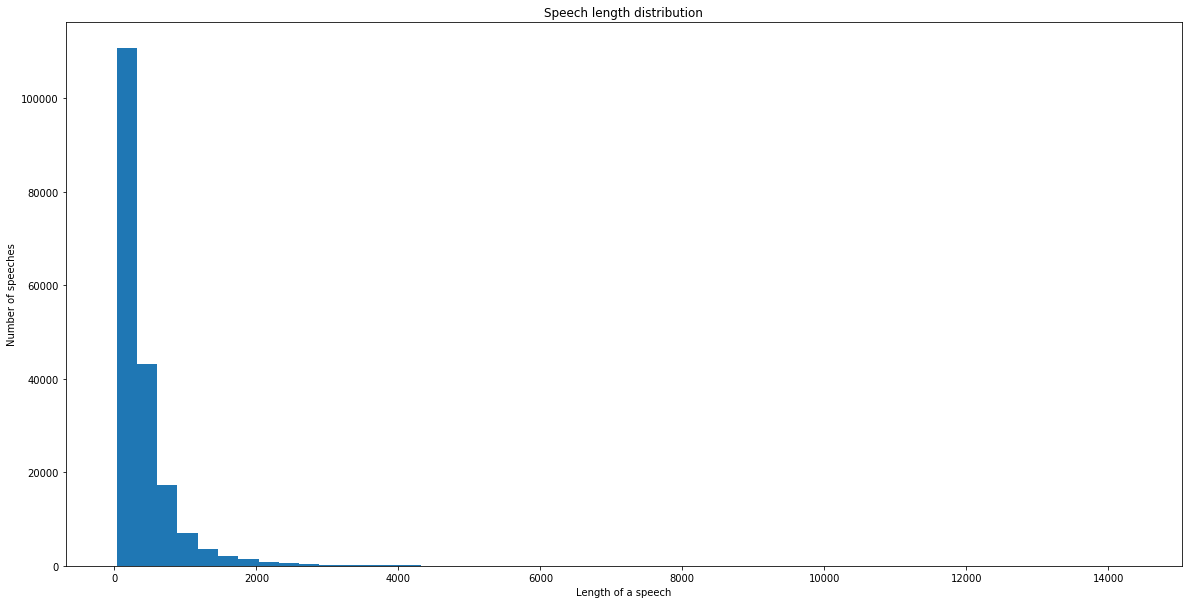

In [18]:
reload(explore_data)
explore_data.plot_sample_length_distribution(train)

#### OPTIONAL: Split speeches into 100-word chunks

In [207]:
# reload(preprocess_data)
# train_chunk, train_ids_chunk, train_target_chunk = preprocess_data.split_speech_to_chunks(train, train_ids, train_target, max_len=100)

Original data has 3244 speeches
It was split into 12496 chunks
Checks on ids and target 12496 12496
Original target mean 0.5
New target mean 0.5060819462227913


In [197]:
# val_chunk, val_ids_chunk, val_target_chunk = preprocess_data.split_speech_to_chunks(val, val_ids, val_target, max_len=100)

Original data has 1080 speeches
It was split into 4252 chunks
Checks on ids and target 4252 4252
Original target mean 0.5
New target mean 0.47765757290686733


In [198]:
# test_chunk, test_ids_chunk, test_target_chunk = preprocess_data.split_speech_to_chunks(test, test_ids, test_target, max_len=100)

Original data has 1084 speeches
It was split into 4189 chunks
Checks on ids and target 4189 4189
Original target mean 0.5
New target mean 0.5301981379804249


### Tokenize speeches

In [13]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
# MAX_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = 750

vec_params = {
    'num_words': TOP_K,
    'max_seq_length': MAX_SEQUENCE_LENGTH
}

In [32]:
# del train_vec, val_vec, test_vec

In [14]:
reload(preprocess_data)
start_time = time.time()
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train, val, test, **vec_params)
print("\nIt took {:.1f} seconds to tokenize the data".format(time.time()-start_time))


It took 143.8 seconds to tokenize the data


In [15]:
len(train), len(val), len(test)

(188148, 62716, 62716)

In [164]:
#len(train_chunk), len(val_chunk), len(test_chunk)

(12370, 4010, 4089)

In [16]:
len(train_vec), len(val_vec), len(test_vec)

(188148, 62716, 62716)

In [17]:
max(map(max, train_vec)), max(map(max, val_vec)), max(map(max, test_vec))

(19999, 19999, 19999)

In [18]:
len(word_index)

474945

In [19]:
train_vec[0].shape

(750,)

In [20]:
train_vec[0][-10:]

array([ 313,    4, 5086,   11,   63,    1, 1366,  343,    2,  161],
      dtype=int32)

In [21]:
train[0]

'Madam Speaker. it is my pleasure to yield 2 minutes to the distinguished gentlelady from California. Congresswoman BARBARA LEE. a member of the Committee on Appropriations and a Member with a long history of advocating for those unempovwered persons around the world.'

In [22]:
for word in train[0].split()[-10:]:
    word = re.sub(r'[^\w\s]','',word)
    print(word, word_index[word])

history 313
of 4
advocating 5086
for 11
those 63
unempovwered 167693
persons 1366
around 343
the 2
world 161


### Saving processed files

In [ ]:
#del descr

In [23]:
token_path = '/home/yulia/final-project/Classification/data/tokenized'

In [24]:
np.save(os.path.join(token_path, 'train_vec'), train_vec)
np.save(os.path.join(token_path, 'val_vec'), val_vec)
np.save(os.path.join(token_path, 'test_vec'), test_vec)

In [7]:
train_vec = np.load(os.path.join(token_path, 'train_vec.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec.npy'))

In [8]:
len(train_vec), len(val_vec), len(test_vec)

(188148, 62716, 62716)

In [ ]:
pickle.dump(word_index, open(os.path.join(token_path, 'word_index.p'), 'wb'))

In [ ]:
word_index = pickle.load(open(os.path.join(token_path, 'word_index.p'), 'rb'))

In [ ]:
del descr

## CNN Models

In [25]:
logs_base_dir = "/home/yulia/final-project/Classification/logs"

In [26]:
cnn_model_params = {
    'model': 'cnn',
    'learning_rate': 0.001,
    'layers': 2,
    'epochs': 1000,
    'batch_size': 128,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 100,
    'kernel_size': 3,
    'pool_size': 1,
    'max_num_words': TOP_K,
    'use_pretrained_embedding': True,
    'is_embedding_trainable': True,
    'glove_dir': '/home/yulia/final-project/data'
}

In [179]:
# train_shuffle = np.random.permutation(np.arange(len(train_target_chunk)))
# train_vec = train_vec[train_shuffle]
# train_target_chunk = np.array(train_target_chunk, dtype=int)[train_shuffle]

In [46]:
#len(train_target_chunk), len(train_target)

In [27]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), word_index, logs_base_dir, **cnn_model_params)

Found 400000 word vectors.
It took 12.5 seconds
Preparing embedding matrix.
20000 20000
Embedding matrix has been built.
Its shape is (20000, 100).
It took 0.1 seconds
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 188148 samples, validate on 62716 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1000
 - 891s - loss: 0.6318 - acc: 0.6429 - val_loss: 0.6040 - val_acc: 0.6735
Epoch 2/1000
 - 897s - loss: 0.6035 - acc: 0.6738 - val_loss: 0.5883 - val_acc: 0.6871
Epoch 3/1000
 - 899s - loss: 0.5931 - acc: 0.6826 - val_loss: 0.5817 - val_acc: 0.6926
Epoch 4/1000
 - 900s - loss: 0.5860 - acc: 0.6880 - val_loss: 0.5777 - val_acc: 0.6994
Epoch 5/1000
 - 910s - loss: 0.5818 - acc: 0.6927 - val_loss: 0.5709 - val_acc: 0.7025
Epoch 6/1000
 - 903s - loss: 0.57

### Clean up space/save outputs

In [44]:
# del train, train_ids, train_pred_probs, train_target, train_vec

In [29]:
probs_path = '/home/yulia/final-project/Classification/data/cnn/gender'

In [30]:
with open(os.path.join(probs_path, 'val_pred_probs'), 'wb') as fp:
    pickle.dump(val_pred_probs, fp)

In [ ]:
with open(os.path.join(probs_path, 'val_pred_probs'), 'rb') as fp:
    val_pred_probs = pickle.load(fp)

## Model evaluation

In [31]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

45198

In [32]:
val_preds.shape, len(val_target)

((62716, 1), 62716)

Confusion matrix, without normalization
[[24431  6927]
 [10591 20767]]


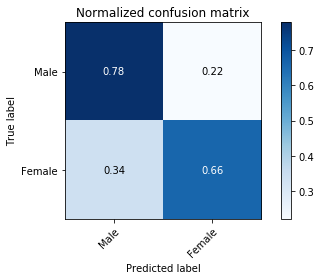

In [33]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

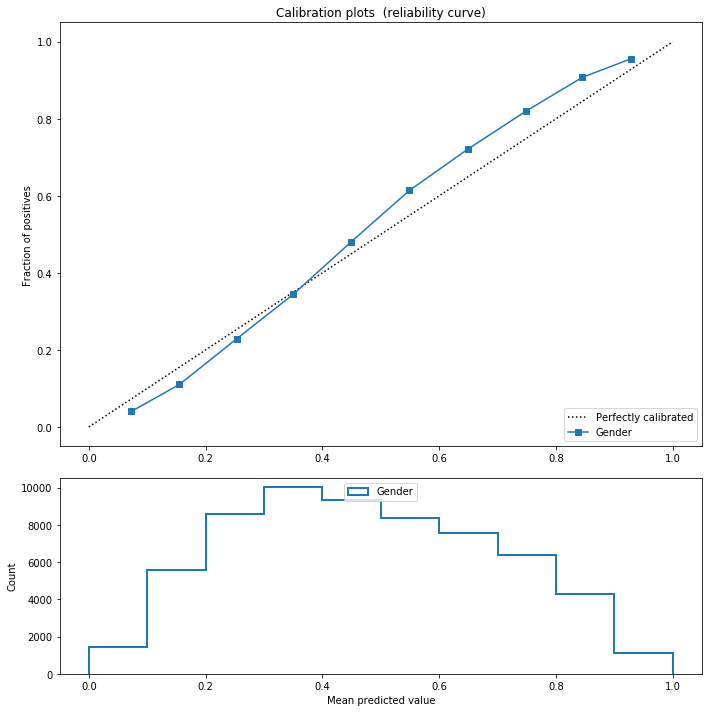

In [35]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [34]:
descr_df = pd.read_csv('/home/yulia/final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.shape

/home/yulia/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(62716, 16)

In [36]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base       0.5       0.173991  58.285477  0.621468   0.659816     387.29868


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.48,0.39,0.99,0.84,0.68,0.94
0.6,1.09,0.99,0.99,0.99,1.17,0.94
1.0,1.62,1.82,1.02,1.22,1.27,1.14


In [38]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
rise 	 2765.8
speaker rise 	 2256.4
mr president 	 1900.5
women 	 1472.8
speaker 	 1338.6
rise today 	 1284.8
colleagues to 	 1146.6
families 	 1058.2
our 	 978.5
mr speaker 	 943.9


bin,1,2,3
colleagues to,2089.0,2743.0,5130.0
families,2195.0,3739.0,9975.0
mr president,17942.0,4117.0,3216.0
mr speaker,10830.0,14348.0,17746.0
our,37790.0,37182.0,61464.0
rise,3356.0,4710.0,9141.0
rise today,1250.0,2017.0,3913.0
speaker,12180.0,16613.0,21643.0
speaker rise,905.0,2079.0,4653.0
women,1609.0,2665.0,17286.0


In [37]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 0.90):

date               20151028
char_count             3522
word_count              570
speakerid       1.14121e+08
Party                     D
Congress                114
Chamber                   H
State                    CA
Ethnicity                 W
Age                      76
Age_lt_med                0
NonWhite                  0
Female                    1
speaker          Ms. PELOSI
Full Name     PELOSI, NANCY
match                 exact
Name: 1140059079, dtype: object

 I thank the gentleman from Maryland for yielding and for his kind words. and I return the compliment to him. To the staff of the Budget Committee. the staff of the other committees of jurisdiction on both sides of the aisle who enabled this important agreement to come forward. thank you very much. Madam Speaker. today we are proud to come to the floor with legislation that moves America forward. affirming the full faith and credit of the United States of America. as our Con

#### Run the following test on a random subset of the validation sample

In [39]:
val_random = np.random.choice(a=[0,1], size=len(val_target), p = [0.7,0.3])
val_random.sum()/val_random.shape[0]

0.3023949231456088

In [40]:
val_sample, val_ids_sample, val_pred_probs_sample = [], [], []
for i in range(len(val_ids)):
    if val_random[i] == 1:
        val_sample.append(val[i])
        val_ids_sample.append(val_ids[i])
        val_pred_probs_sample.append(val_pred_probs[i])
len(val_sample), len(val_ids_sample), len(val_pred_probs_sample)

(18965, 18965, 18965)

In [41]:
reload(explore_data)
explore_data.ngrams_by_bin(val_sample, val_pred_probs_sample)


In 0.4 bin top 10 ngrams:

the united states
the senator from
the gentleman from
are going to
would like to
one of the
ask unanimous consent
of the united
chairman of the
the american people
--------------------

In 0.6 bin top 10 ngrams:

the united states
the gentleman from
one of the
my colleagues to
the american people
would like to
are going to
of the united
we need to
mr speaker rise
--------------------

In 1.0 bin top 10 ngrams:

the united states
my colleagues to
one of the
mr speaker rise
urge my colleagues
the american people
urge my colleagues to
we need to
would like to
speaker rise today
--------------------
